In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import time
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
class Matryoshka_CE_Loss(nn.Module):
    def __init__(self, relative_importance=None, **kwargs):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(**kwargs)
        self.relative_importance = relative_importance

    def forward(self, output, target):
        losses = torch.stack([self.criterion(output_i, target) for output_i in output])
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.as_tensor(self.relative_importance, device=losses.device).clone().detach()        
        weighted_losses = rel_importance * losses
        return weighted_losses.mean()

class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list, num_classes=100, efficient=False, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes
        self.efficient = efficient
        if self.efficient:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, **kwargs)
        else:
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, **kwargs))

    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            if self.efficient:
                if self.nesting_classifier_0.bias is None:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()), )
                else:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()) + self.nesting_classifier_0.bias, )
            else:
                nesting_logits += (getattr(self, f"nesting_classifier_{i}")(x[:, :num_feat]),)
        return nesting_logits


In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet9(nn.Module):
    def __init__(self, nesting_list, num_classes=100):
        super(ResNet9, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        
        self.linear = MRL_Linear_Layer(nesting_list, num_classes=num_classes, efficient=False)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=1)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
nesting_list = [8, 16, 32, 64, 128, 256]
relative_importance = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
relative_importance_tensor = torch.tensor(relative_importance, device=device)

model = ResNet9(nesting_list, num_classes=100)
model = model.to(device)

In [7]:
def train(epoch):
    model.train()
    train_loss = 0
    correct = {n: 0 for n in nesting_list}
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        for i, n in enumerate(nesting_list):
            _, predicted = outputs[i].max(1)
            correct[n] += predicted.eq(targets).sum().item()
        total += targets.size(0)

    avg_acc = 100. * sum(correct.values()) / (total * len(nesting_list))
    print(f"| {'Train':^6} {epoch:^3} | Loss: {train_loss/(batch_idx+1):^7.3f} | Acc: {avg_acc:^6.3f}% |")

In [8]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct_top1 = {n: 0 for n in nesting_list}
    correct_top5 = {n: 0 for n in nesting_list}
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            for i, n in enumerate(nesting_list):
                _, predicted = outputs[i].max(1)
                correct_top1[n] += predicted.eq(targets).sum().item()
                
                _, top5_pred = outputs[i].topk(5, 1, True, True)
                correct_top5[n] += top5_pred.eq(targets.view(-1, 1)).sum().item()
            
            total += targets.size(0)

    avg_top1 = sum(100. * correct_top1[n] / total for n in nesting_list) / len(nesting_list)
    avg_top5 = sum(100. * correct_top5[n] / total for n in nesting_list) / len(nesting_list)
    
    print("\n┌──────────┬────────────┬────────────┐")
    print(f"│ {'Size':^8} │ {'Top-1 Acc':^10} │ {'Top-5 Acc':^10} │")
    print("├──────────┼────────────┼────────────┤")
    
    for n in nesting_list:
        top1 = 100. * correct_top1[n] / total
        top5 = 100. * correct_top5[n] / total
        print(f"│ {n:^8} │ {top1:>9.2f}% │ {top5:>9.2f}% │")
    
    print("├──────────┼────────────┼────────────┤")
    print(f"│ {'Average':^8} │ {avg_top1:>9.2f}% │ {avg_top5:>9.2f}% │")
    print("└──────────┴────────────┴────────────┘")
    
    return avg_top1 

In [9]:
criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

| Train   0  | Loss:  4.049  | Acc: 7.457 % |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │      7.04% │     25.03% │
│    16    │      9.22% │     30.27% │
│    32    │     10.22% │     31.87% │
│    64    │     10.58% │     33.01% │
│   128    │     10.94% │     32.83% │
│   256    │     10.62% │     32.97% │
├──────────┼────────────┼────────────┤
│ Average  │      9.77% │     31.00% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:21
--------------------------------------------------------------------------------
| Train   1  | Loss:  3.488  | Acc: 15.150% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     12.16% │     34.96% │
│    16    │     15.67% │     43.37% │
│    32    │     16.03% │     43.43% │
│    64    │     15.92% │     43.80% │
│   128    │     15.76% │     43.65% │
│   256    │     15.85% │

| Train  14  | Loss:  1.616  | Acc: 54.511% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     35.57% │     68.16% │
│    16    │     46.06% │     77.24% │
│    32    │     49.48% │     79.53% │
│    64    │     50.14% │     80.10% │
│   128    │     50.31% │     80.27% │
│   256    │     50.30% │     80.42% │
├──────────┼────────────┼────────────┤
│ Average  │     46.98% │     77.62% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  15  | Loss:  1.591  | Acc: 55.274% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     40.27% │     73.40% │
│    16    │     48.53% │     79.95% │
│    32    │     51.81% │     81.56% │
│    64    │     52.04% │     81.95% │
│   128    │     52.40% │     82.09% │
│   256    │     52.59% │

| Train  28  | Loss:  1.365  | Acc: 61.728% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     41.45% │     71.59% │
│    16    │     50.53% │     78.99% │
│    32    │     52.96% │     81.36% │
│    64    │     53.66% │     81.83% │
│   128    │     53.76% │     81.87% │
│   256    │     53.75% │     81.93% │
├──────────┼────────────┼────────────┤
│ Average  │     51.02% │     79.59% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:21
--------------------------------------------------------------------------------
| Train  29  | Loss:  1.354  | Acc: 61.862% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     41.58% │     72.55% │
│    16    │     50.43% │     78.82% │
│    32    │     53.86% │     81.56% │
│    64    │     54.19% │     82.38% │
│   128    │     54.41% │     82.51% │
│   256    │     54.49% │

| Train  42  | Loss:  1.251  | Acc: 64.764% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     44.85% │     75.97% │
│    16    │     54.52% │     82.06% │
│    32    │     58.17% │     84.61% │
│    64    │     58.53% │     85.11% │
│   128    │     58.71% │     85.23% │
│   256    │     58.74% │     85.24% │
├──────────┼────────────┼────────────┤
│ Average  │     55.59% │     83.04% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:21
--------------------------------------------------------------------------------
| Train  43  | Loss:  1.241  | Acc: 65.128% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     43.44% │     74.40% │
│    16    │     51.90% │     80.61% │
│    32    │     55.61% │     83.42% │
│    64    │     55.86% │     83.88% │
│   128    │     55.90% │     84.01% │
│   256    │     55.89% │

| Train  56  | Loss:  1.164  | Acc: 67.210% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     47.98% │     77.80% │
│    16    │     55.37% │     83.57% │
│    32    │     58.09% │     85.24% │
│    64    │     58.77% │     85.91% │
│   128    │     58.83% │     86.02% │
│   256    │     58.85% │     86.03% │
├──────────┼────────────┼────────────┤
│ Average  │     56.32% │     84.09% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  57  | Loss:  1.152  | Acc: 67.484% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     44.47% │     75.47% │
│    16    │     51.86% │     80.58% │
│    32    │     54.49% │     83.13% │
│    64    │     55.28% │     83.75% │
│   128    │     55.26% │     83.89% │
│   256    │     55.28% │

| Train  70  | Loss:  1.063  | Acc: 70.156% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     48.73% │     78.06% │
│    16    │     57.70% │     84.26% │
│    32    │     59.20% │     86.06% │
│    64    │     59.35% │     86.75% │
│   128    │     59.44% │     86.78% │
│   256    │     59.47% │     86.80% │
├──────────┼────────────┼────────────┤
│ Average  │     57.31% │     84.78% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:21
--------------------------------------------------------------------------------
| Train  71  | Loss:  1.066  | Acc: 70.173% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     43.90% │     73.18% │
│    16    │     52.45% │     79.82% │
│    32    │     55.47% │     82.54% │
│    64    │     56.29% │     83.44% │
│   128    │     56.35% │     83.47% │
│   256    │     56.38% │

| Train  84  | Loss:  0.958  | Acc: 73.078% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     51.03% │     78.56% │
│    16    │     59.33% │     84.34% │
│    32    │     61.24% │     86.53% │
│    64    │     61.81% │     87.21% │
│   128    │     61.82% │     87.23% │
│   256    │     61.82% │     87.26% │
├──────────┼────────────┼────────────┤
│ Average  │     59.51% │     85.19% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:21
--------------------------------------------------------------------------------
| Train  85  | Loss:  0.944  | Acc: 73.499% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     47.45% │     75.50% │
│    16    │     56.05% │     82.49% │
│    32    │     57.94% │     84.87% │
│    64    │     58.08% │     85.33% │
│   128    │     58.13% │     85.42% │
│   256    │     58.13% │

| Train  98  | Loss:  0.832  | Acc: 76.763% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     51.98% │     79.60% │
│    16    │     60.47% │     85.91% │
│    32    │     63.08% │     88.03% │
│    64    │     63.56% │     88.42% │
│   128    │     63.55% │     88.44% │
│   256    │     63.57% │     88.46% │
├──────────┼────────────┼────────────┤
│ Average  │     61.03% │     86.48% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:21
--------------------------------------------------------------------------------
| Train  99  | Loss:  0.846  | Acc: 76.123% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     55.00% │     81.24% │
│    16    │     62.87% │     86.47% │
│    32    │     65.27% │     88.69% │
│    64    │     65.67% │     89.21% │
│   128    │     65.72% │     89.17% │
│   256    │     65.73% │

| Train  112 | Loss:  0.697  | Acc: 80.550% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     54.88% │     81.31% │
│    16    │     63.97% │     86.73% │
│    32    │     65.92% │     88.88% │
│    64    │     66.48% │     89.24% │
│   128    │     66.46% │     89.28% │
│   256    │     66.47% │     89.30% │
├──────────┼────────────┼────────────┤
│ Average  │     64.03% │     87.46% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:20
--------------------------------------------------------------------------------
| Train  113 | Loss:  0.690  | Acc: 80.593% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     55.48% │     81.66% │
│    16    │     63.42% │     87.23% │
│    32    │     65.69% │     89.47% │
│    64    │     66.06% │     89.91% │
│   128    │     66.16% │     89.88% │
│   256    │     66.16% │

| Train  126 | Loss:  0.541  | Acc: 85.354% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     57.38% │     83.12% │
│    16    │     64.98% │     88.06% │
│    32    │     67.00% │     89.89% │
│    64    │     67.55% │     90.30% │
│   128    │     67.51% │     90.35% │
│   256    │     67.54% │     90.35% │
├──────────┼────────────┼────────────┤
│ Average  │     65.33% │     88.68% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:21
--------------------------------------------------------------------------------
| Train  127 | Loss:  0.531  | Acc: 85.626% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     57.01% │     81.43% │
│    16    │     64.79% │     86.57% │
│    32    │     66.77% │     88.75% │
│    64    │     67.14% │     89.26% │
│   128    │     67.19% │     89.33% │
│   256    │     67.19% │

| Train  140 | Loss:  0.362  | Acc: 90.917% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     59.61% │     83.06% │
│    16    │     67.10% │     87.68% │
│    32    │     68.94% │     89.69% │
│    64    │     69.26% │     89.85% │
│   128    │     69.26% │     89.88% │
│   256    │     69.29% │     89.88% │
├──────────┼────────────┼────────────┤
│ Average  │     67.24% │     88.34% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:21
--------------------------------------------------------------------------------
| Train  141 | Loss:  0.349  | Acc: 91.459% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     59.29% │     83.01% │
│    16    │     66.44% │     87.62% │
│    32    │     68.65% │     89.61% │
│    64    │     68.77% │     89.96% │
│   128    │     68.80% │     89.96% │
│   256    │     68.80% │

| Train  154 | Loss:  0.175  | Acc: 96.962% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     64.80% │     85.59% │
│    16    │     70.96% │     89.50% │
│    32    │     72.29% │     90.75% │
│    64    │     72.46% │     91.03% │
│   128    │     72.47% │     91.07% │
│   256    │     72.47% │     91.07% │
├──────────┼────────────┼────────────┤
│ Average  │     70.91% │     89.83% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:21
--------------------------------------------------------------------------------
| Train  155 | Loss:  0.165  | Acc: 97.259% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     64.66% │     85.70% │
│    16    │     70.80% │     89.72% │
│    32    │     72.32% │     91.14% │
│    64    │     72.60% │     91.46% │
│   128    │     72.61% │     91.46% │
│   256    │     72.61% │

| Train  168 | Loss:  0.073  | Acc: 99.589% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     69.94% │     87.75% │
│    16    │     74.85% │     90.99% │
│    32    │     75.72% │     92.06% │
│    64    │     75.94% │     92.40% │
│   128    │     75.93% │     92.41% │
│   256    │     75.94% │     92.40% │
├──────────┼────────────┼────────────┤
│ Average  │     74.72% │     91.33% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:21
--------------------------------------------------------------------------------
| Train  169 | Loss:  0.069  | Acc: 99.676% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     69.90% │     87.47% │
│    16    │     75.00% │     90.95% │
│    32    │     76.03% │     92.12% │
│    64    │     76.08% │     92.32% │
│   128    │     76.10% │     92.34% │
│   256    │     76.08% │

| Train  182 | Loss:  0.051  | Acc: 99.885% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     71.32% │     88.14% │
│    16    │     75.52% │     91.45% │
│    32    │     76.34% │     92.46% │
│    64    │     76.49% │     92.68% │
│   128    │     76.49% │     92.69% │
│   256    │     76.49% │     92.70% │
├──────────┼────────────┼────────────┤
│ Average  │     75.44% │     91.69% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:21
--------------------------------------------------------------------------------
| Train  183 | Loss:  0.050  | Acc: 99.911% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     71.32% │     88.24% │
│    16    │     75.63% │     91.55% │
│    32    │     76.26% │     92.62% │
│    64    │     76.48% │     92.80% │
│   128    │     76.50% │     92.79% │
│   256    │     76.50% │

| Train  196 | Loss:  0.045  | Acc: 99.947% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     71.69% │     88.36% │
│    16    │     75.95% │     91.64% │
│    32    │     76.63% │     92.67% │
│    64    │     76.74% │     92.84% │
│   128    │     76.72% │     92.86% │
│   256    │     76.72% │     92.86% │
├──────────┼────────────┼────────────┤
│ Average  │     75.74% │     91.87% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:21
--------------------------------------------------------------------------------
| Train  197 | Loss:  0.046  | Acc: 99.934% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     71.61% │     88.27% │
│    16    │     75.92% │     91.58% │
│    32    │     76.44% │     92.66% │
│    64    │     76.52% │     92.82% │
│   128    │     76.52% │     92.85% │
│   256    │     76.52% │

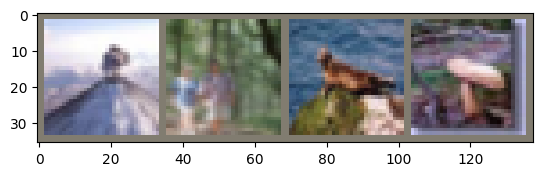

GroundTruth:	 49	33	72	51
Size		Image 1	Image 2	Image 3	Image 4
8		49	33	27	51
16		12	33	72	51
32		15	33	27	51
64		49	33	27	51
128		49	33	27	51
256		49	33	27	51


In [10]:
total_start_time = time.time()
epoch_times = []

best_acc = 0
for epoch in range(200):
    epoch_start = time.time()
    train(epoch)
    acc = test(epoch)
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model_resnet9_mrl.pth')
    print(f'Epoch time: {timedelta(seconds=int(epoch_time))}')
    print('-' * 80)

total_time = time.time() - total_start_time
print(f'Total training time: {timedelta(seconds=int(total_time))}')
print(f'Average epoch time: {timedelta(seconds=int(sum(epoch_times)/len(epoch_times)))}')    

print(f'Best Test Accuracy: {best_acc:.2f}%')

def imshow(img):
    img = img * torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1) + \
          torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:\t', '\t'.join(f'{labels[j]}' for j in range(4)))

print("Size\t\t" + "\t".join(f"Image {j+1}" for j in range(4)))
outputs = model(images[:4].to(device))
for i, n in enumerate(nesting_list):
    _, predicted = torch.max(outputs[i], 1)
    print(f"{n}\t\t" + "\t".join(f"{predicted[j].item()}" for j in range(4)))